In [1]:
from bagpy import bagreader
import rosbag
from quat_utils import Quat2Euler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_name = 'dados'
b = bagreader('../bags/' + file_name + '.bag')
b.topic_table

[INFO]  Data folder ../bags/dados already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/clock,rosgraph_msgs/Clock,24751,1000.0
1,/desired_trajectory,quad_ufabc/CartesianPointStamped,2363,100.0
2,/gazebo/link_states,gazebo_msgs/LinkStates,24613,NaN
3,/gazebo/model_states,gazebo_msgs/ModelStates,24611,1000.0
4,/gazebo/parameter_descriptions,dynamic_reconfigure/ConfigDescription,1,NaN
5,/gazebo/parameter_updates,dynamic_reconfigure/Config,1,NaN
6,/gazebo/performance_metrics,gazebo_msgs/PerformanceMetrics,245,10.0
7,/quad/control/attitude_controller_error,quad_ufabc/AttitudeControllerErrorStamped,2363,100.0
8,/quad/control/attitude_controller_output,quad_ufabc/AttitudeControllerOutputStamped,2363,100.0
9,/quad/control/position_controller_output,quad_ufabc/PositionControllerOutputStamped,2363,100.0


In [3]:
imu_data = b.message_by_topic(topic='/quad/imu')
imu_data_df = pd.read_csv(imu_data)
list(imu_data_df)

['Time',
 'header.seq',
 'header.stamp.secs',
 'header.stamp.nsecs',
 'header.frame_id',
 'orientation.x',
 'orientation.y',
 'orientation.z',
 'orientation.w',
 'orientation_covariance_0',
 'orientation_covariance_1',
 'orientation_covariance_2',
 'orientation_covariance_3',
 'orientation_covariance_4',
 'orientation_covariance_5',
 'orientation_covariance_6',
 'orientation_covariance_7',
 'orientation_covariance_8',
 'angular_velocity.x',
 'angular_velocity.y',
 'angular_velocity.z',
 'angular_velocity_covariance_0',
 'angular_velocity_covariance_1',
 'angular_velocity_covariance_2',
 'angular_velocity_covariance_3',
 'angular_velocity_covariance_4',
 'angular_velocity_covariance_5',
 'angular_velocity_covariance_6',
 'angular_velocity_covariance_7',
 'angular_velocity_covariance_8',
 'linear_acceleration.x',
 'linear_acceleration.y',
 'linear_acceleration.z',
 'linear_acceleration_covariance_0',
 'linear_acceleration_covariance_1',
 'linear_acceleration_covariance_2',
 'linear_accel

In [4]:
# IMU information

t_imu = imu_data_df['Time'].to_numpy()

p_imu = imu_data_df['angular_velocity.x'].to_numpy()
q_imu = imu_data_df['angular_velocity.y'].to_numpy()
r_imu = imu_data_df['angular_velocity.z'].to_numpy()

q_imu_w = imu_data_df['orientation.w'].to_numpy()
q_imu_x = imu_data_df['orientation.x'].to_numpy()
q_imu_y = imu_data_df['orientation.y'].to_numpy()
q_imu_z = imu_data_df['orientation.z'].to_numpy()

phi_imu = np.zeros(len(q_imu_w))
theta_imu = np.zeros(len(q_imu_w))
psi_imu = np.zeros(len(q_imu_w))

for i in range(len(q_imu_w)):
    q = np.array([q_imu_w[i], q_imu_x[i], q_imu_y[i], q_imu_z[i]])
    euler = Quat2Euler(q)
    phi_imu[i] = euler[0]
    theta_imu[i] = euler[1]
    psi_imu[i] = euler[2]

In [5]:
#  Control information U = (u1, u2, u3, u4)
pos_control_out = b.message_by_topic(topic='/quad/control/position_controller_output')
pos_control_out_df = pd.read_csv(pos_control_out)
u1 = pos_control_out_df['position_controller_output.thrust.num'].to_numpy()

att_control_out = b.message_by_topic(topic='/quad/control/attitude_controller_output')
att_control_out_df = pd.read_csv(att_control_out)
u2 = att_control_out_df['torques.x'].to_numpy()
u3 = att_control_out_df['torques.y'].to_numpy()
u4 = att_control_out_df['torques.z'].to_numpy()

t_u = pos_control_out_df['Time'].to_numpy()

In [6]:
# real position
bag=rosbag.Bag('../bags/' + file_name + '.bag')
q_atual_x = []
q_atual_y = []
q_atual_z = []
q_atual_w = []
wx = []
wy = []
wz = []
t_q =[]
idx = 2
for topic, msg, t in bag.read_messages(topics=['/gazebo/model_states']):
    q_atual_x = np.append(q_atual_x, msg.pose[idx].orientation.x)
    q_atual_y = np.append(q_atual_y, msg.pose[idx].orientation.y)
    q_atual_z = np.append(q_atual_z, msg.pose[idx].orientation.z)
    q_atual_w = np.append(q_atual_w, msg.pose[idx].orientation.w)
    wx = np.append(wx, msg.twist[idx].angular.x)
    wy = np.append(wy, msg.twist[idx].angular.y)
    wz = np.append(wz, msg.twist[idx].angular.z)
    t_q = np.append(t_q, t.to_sec()) 
bag.close()
q_atual=np.array([q_atual_w, q_atual_x, q_atual_y, q_atual_z])
euler_atual=[]
for i in range(len(q_atual[0])):
    euler_atual = np.append(euler_atual, Quat2Euler(q_atual[:,i]))
euler_atual = euler_atual.reshape((len(q_atual[0]),3))


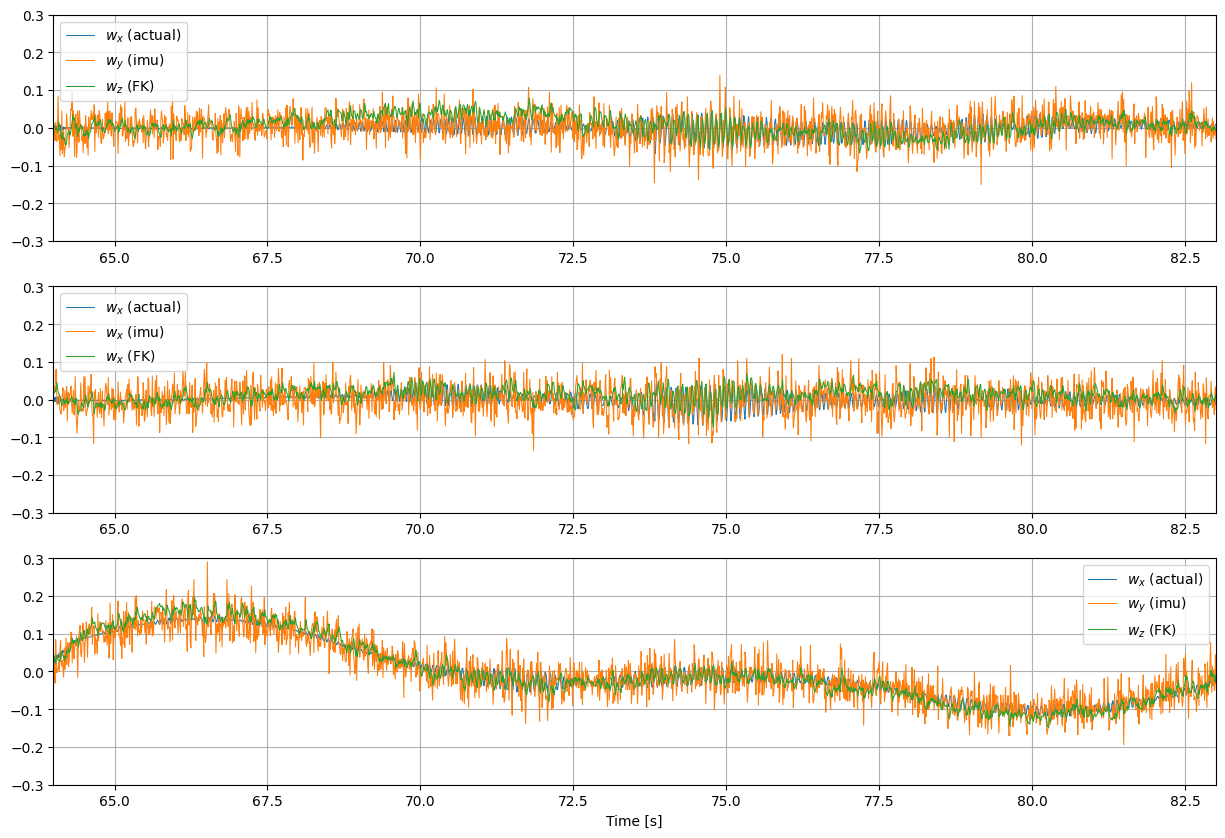

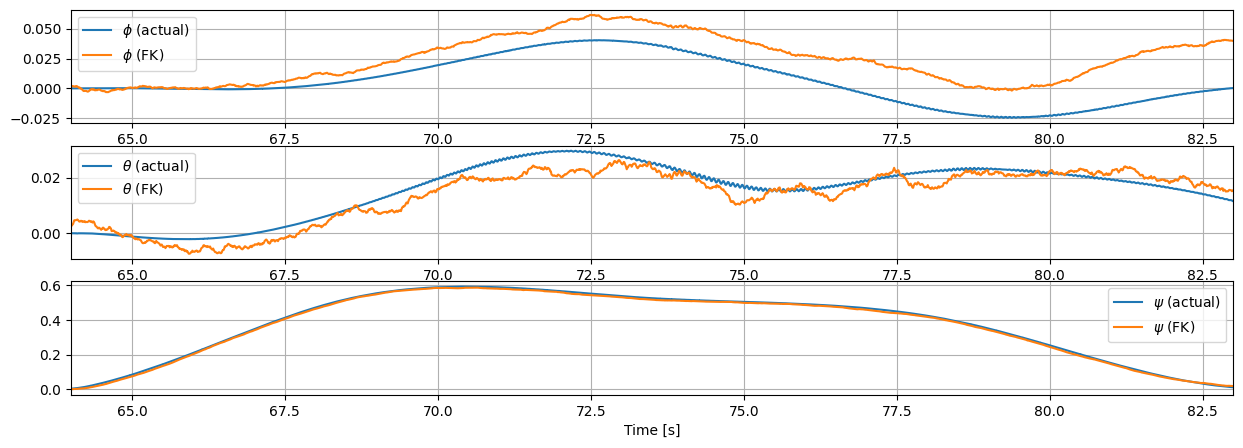

In [7]:
# Parâmetros do sistema linear discetizado
# supondo IrOmega = 0
Ixx = 16.83*10**-3
Iyy = 16.83*10**-3
Izz = 28.34*10**-3
dt = t_imu[1]-t_imu[0]
A = np.zeros((6,6))
A[0,3]=1
A[1,4]=1
A[2,5]=1
B = np.zeros((6,3))
B[3,0]=1/Ixx
B[4,1]=1/Iyy
B[5,2]=1/Izz
C = np.zeros((3,6))
C[0,3]=1
C[1,4]=1
C[2,5]=1
# 
Phi = np.eye(6) + A*dt
Gamma = B*dt
ang_vel_stddev = 3.5e-2
proc_noise_stddev = 1.0e-2
H = C
#Q = np.eye(6)*0.04 #0.04
#R = np.eye(3)*0.2 #0.2
Q = np.eye(6)*proc_noise_stddev**2
R = np.eye(3)*ang_vel_stddev**2
P = np.eye(6)*0.1
K = np.zeros((6,3))

N = min(len(t_imu),len(t_u))
x = np.zeros((6,N))
y = np.array([p_imu[:N],q_imu[:N],r_imu[:N]]).reshape(3,N)
x[:,0] = np.array([np.zeros((3,1)),y[:,0].reshape(3,1)]).reshape(6)
# ------------------
# Filtro de Kalman
# ------------------
def kalman_filter(x0,P0,Phi,Gamma,H,R,Q,y,u):
    # Prediction
    x = Phi@x0 + Gamma@u
    P = Phi@P0@Phi.T + Q
    # Update
    K = P@H.T@np.linalg.inv(H@P@H.T + R)
    x = x + K@(y - H@x)
    P = (np.eye(6) - K@H)@P    
    return x.reshape(x0.shape), P.reshape(P0.shape)
# ------------------
t_kf = np.zeros(N)
t_kf[0] = t_imu[0]
for i in range(N-1):
    x[:,i+1], P = kalman_filter(x[:,i],P,Phi,Gamma,H,R,Q,y[:,i],np.array([u2[i],u3[i],u4[i]]).reshape(3))
    t_kf[i+1] = t_kf[i]+dt
# ------------------
# Plotting the raw data from IMU
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
#plt.title('Angular velocities')
plt.plot(t_q, wx, label='$w_x$ (actual)', linewidth=0.75)
plt.plot(t_imu, p_imu, label='$w_y$ (imu)', linewidth=0.75)
plt.plot(t_kf, x[3,:], label='$w_z$ (FK)', linewidth=0.75)
plt.xlim(64,83)
plt.ylim(-0.3,0.3)
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t_q, wy, label='$w_x$ (actual)', linewidth=0.75)#, linewidth=0.5)
plt.plot(t_imu, q_imu, label='$w_x$ (imu)', linewidth=0.75)#, linestyle=':', linewidth=0.5)
plt.plot(t_kf,x[4,:], label='$w_x$ (FK)', linewidth=0.75)#, linewidth=0.5)
plt.xlim(64, 83)
plt.ylim(-0.3,0.3)
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t_q, wz, label='$w_x$ (actual)', linewidth=0.75)#, linewidth=0.5)
plt.plot(t_imu, r_imu, label='$w_y$ (imu)', linewidth=0.75)#, linestyle=':', linewidth=0.5)
plt.plot(t_kf,x[5,:], label='$w_z$ (FK)', linewidth=0.75)#, linewidth=0.5 )
plt.xlim(64, 83)
plt.ylim(-0.3,0.3)
plt.grid()
plt.xlabel('Time [s]')
plt.legend()
plt.show()
#
plt.figure(figsize=(15, 5))
plt.subplot(3, 1, 1)
#plt.title('Atitudes')
plt.plot(t_q, euler_atual[:,0], label='$\phi$ (actual)')
#plt.plot(t_imu, phi_imu, label='$\phi$ (imu)')#, alpha=1.0, linestyle=':')
plt.plot(t_kf,x[0,:], label='$\phi$ (FK)' )
plt.xlim(64,83)
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t_q, euler_atual[:,1], label='$\\theta$ (actual)')
#plt.plot(t_imu, theta_imu, label='$\\theta$ (imu)')#, alpha=1.0, linestyle=':')
plt.plot(t_kf,x[1,:], label='$\\theta$ (FK)' )
plt.xlim(64,83)
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t_q, euler_atual[:,2], label='$\psi$ (actual)')
#plt.plot(t_imu, psi_imu, label='$\psi$ (imu)')#, alpha=1.0, linestyle=':')
plt.plot(t_kf,x[2,:], label='$\psi$ (FK)' )
plt.xlim(64,83)
plt.grid()
plt.xlabel('Time [s]')
plt.legend()
plt.show()

# Filtro de Kalman Estendido (EKF)

In [8]:
'''Extended Kalman Filter
extended_kalman_filter : extended_kalman_filter(x0,P0,f,Phi,H,R,Q,y,u)
f : f(x,u,Ir,Omr,Ixx,Iyy,Izz)
Dfx : Dfx(x,Ir,Omr,Ixx,Iyy,Izz)
'''

'Extended Kalman Filter\nextended_kalman_filter : extended_kalman_filter(x0,P0,f,Phi,H,R,Q,y,u)\nf : f(x,u,Ir,Omr,Ixx,Iyy,Izz)\nDfx : Dfx(x,Ir,Omr,Ixx,Iyy,Izz)\n'

In [9]:
# --------------------------
# Filtro de Kalman Estendido
# --------------------------
def extended_kalman_filter(x0,f,P0,Dfx,R,Q,H,y,u,dt,Ir,Omr,Ixx,Iyy,Izz):
    x = f(x0,u,Ir,Omr,Ixx,Iyy,Izz)
    P = Dfx(x, dt, Ir, Omr, Ixx, Iyy, Izz)@P0@Dfx(x, dt, Ir, Omr, Ixx, Iyy, Izz).T + Q
    K = P@H.T@np.linalg.inv(H@P@H.T + R)
    x = x + K@(y - H@x)
    P = (np.eye(6) - K@H)@P 
    return x.reshape(x0.shape), P.reshape(P0.shape)
# ------------------

In [10]:
# Extended Kalman Filter
# ------------------
def f(x,u,Ir,Omr,Ixx,Iyy,Izz):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    x5 = x[4]
    x6 = x[5]
    U1 = u[0]
    U2 = u[1]
    U3 = u[2]
    out = np.array([x6*np.cos(x1)*np.tan(x2) + x5*np.sin(x1)*np.tan(x2) + x4,
                    x5*np.cos(x1) - x6*np.sin(x1),
                    x6*np.cos(x1)/np.cos(x2) + x5*np.sin(x1)/np.cos(x2),
                    -(Ir*Omr*x5 - (Iyy - Izz)*x5*x6 - U1)/Ixx,
                    (Ir*Omr*x4 - (Ixx - Izz)*x4*x6 + U2)/Iyy,
                    ((Ixx - Iyy)*x4*x5 + U3)/Izz])
    return out.reshape(x.shape)
# ------------------
def Dfx(x, dt, Ir, Omr, Ixx, Iyy, Izz):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    x5 = x[4]
    x6 = x[5]
    out = np.zeros((6,6))
    out[0,0] = (x5*np.cos(x1)*np.sin(x2) - x6*np.sin(x1)*np.sin(x2))/np.cos(x2)
    out[0,1] = (x6*np.cos(x1) + x5*np.sin(x1))/np.cos(x2)**2
    out[0,2] = 0
    out[0,3] = 1
    out[0,4] = np.sin(x1)*np.sin(x2)/np.cos(x2)
    out[0,5] = np.cos(x1)*np.sin(x2)/np.cos(x2)
    out[1,0] = -x5*np.sin(x1) - x6*np.cos(x1)
    out[1,1] = 0
    out[1,2] = 0
    out[1,3] = 0
    out[1,4] = np.cos(x1)
    out[1,5] = -np.sin(x1)
    out[2,0] = (x5*np.cos(x1))/np.cos(x2) - (x6*np.sin(x1))/np.cos(x2)
    out[2,1] = (x6*np.cos(x1) + x5*np.sin(x1))*np.sin(x2)/np.cos(x2)**2
    out[2,2] = 0
    out[2,3] = 0
    out[2,4] = np.sin(x1)/np.cos(x2)
    out[2,5] = np.cos(x1)/np.cos(x2)
    out[3,0] = 0
    out[3,1] = 0
    out[3,2] = 0
    out[3,3] = 0
    out[3,4] = -(Ir*Omr - (Iyy - Izz)*x6)/Ixx
    out[3,5] = (Iyy - Izz)*x5/Ixx
    out[4,0] = 0
    out[4,1] = 0
    out[4,2] = 0
    out[4,3] = (Ir*Omr - (Ixx - Izz)*x6)/Iyy
    out[4,4] = 0
    out[4,5] = -(Ixx - Izz)*x4/Iyy
    out[5,0] = 0
    out[5,1] = 0
    out[5,2] = 0
    out[5,3] = (Ixx - Iyy)*x5/Izz
    out[5,4] = (Ixx - Iyy)*x4/Izz
    out[5,5] = 0
    #print(out)
    return np.eye(6) + dt*out
    
Dfu = np.zeros((6,3))
Dfu[3,0] = 1/Ixx
Dfu[4,1] = 1/Iyy
Dfu[5,2] = 1/Izz
Dgx = np.zeros((3,6))
Dgx[0,3] = 1
Dgx[1,4] = 1
Dgx[2,5] = 1

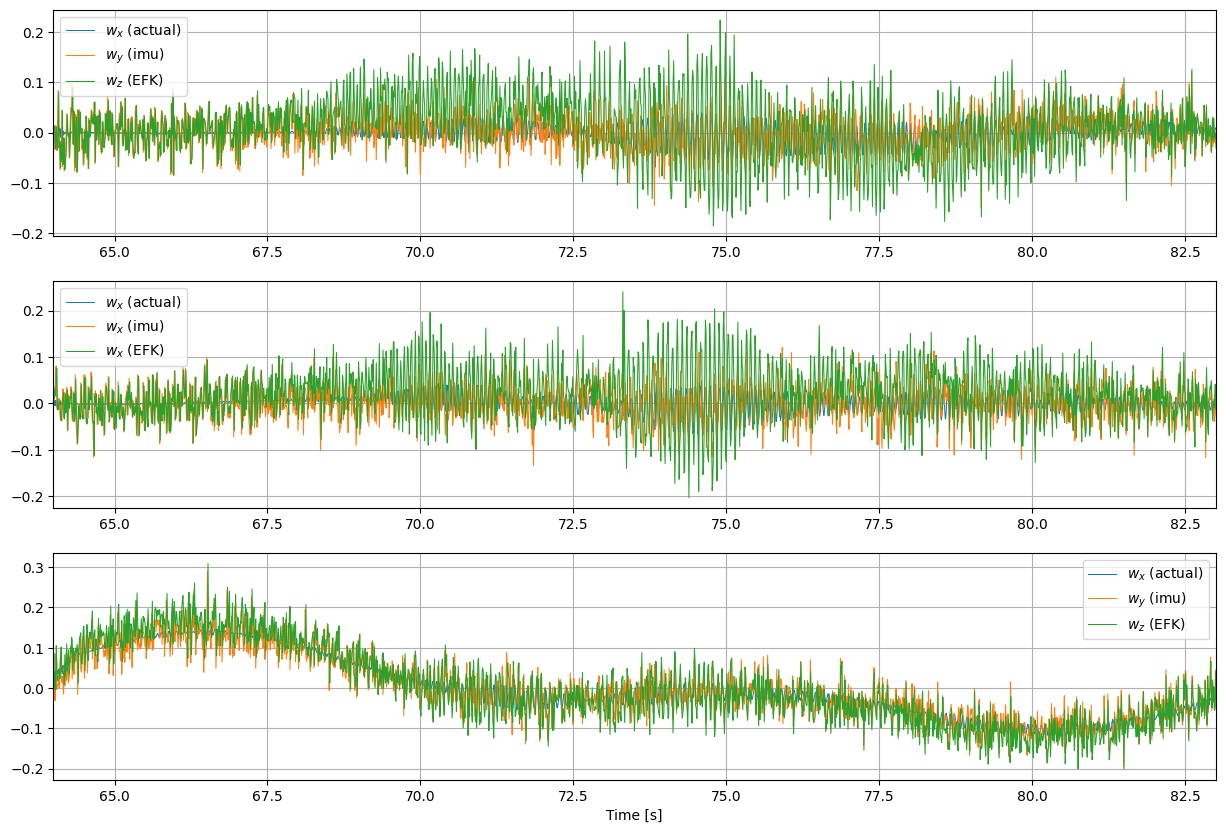

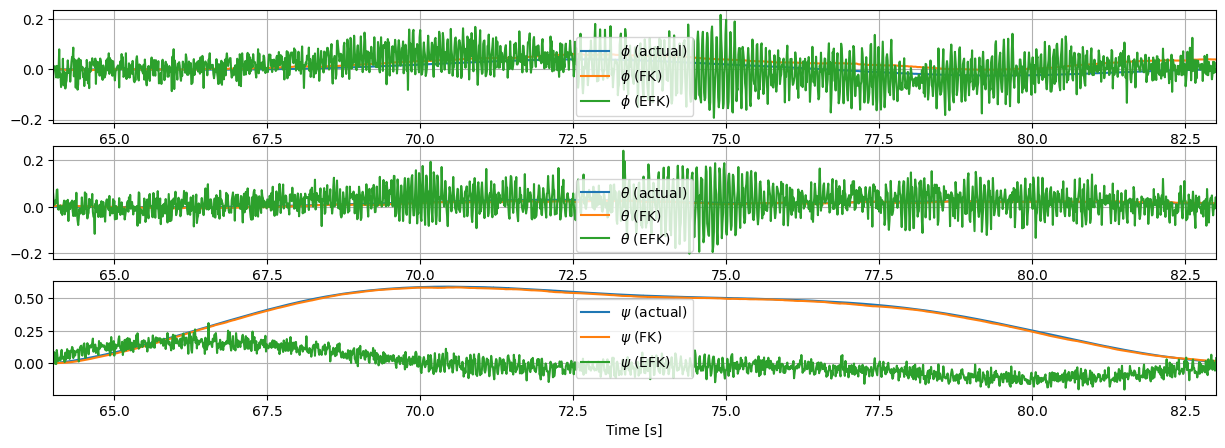

In [46]:
ang_vel_stddev = 3.5e-2
proc_noise_stddev = 1.5e-1
Q = np.eye(6)*proc_noise_stddev**2
R = np.eye(3)*ang_vel_stddev**2
P = np.eye(6)*0.1
K = np.zeros((6,3))
# ------------------
x_ekf = np.zeros((6,N))
x_ekf[:,0] = np.array([np.zeros((3,1)),y[:,0].reshape(3,1)]).reshape(6)
t_ekf = np.zeros(N)
t_ekf[0] = t_imu[0]
Gamma_ekf = Dfu*dt
H_ekf = Dgx
Ir = 0
Omr = 0
# def extended_kalman_filter(x0,f,P0,Dfx,R,Q,H,y,u,Ir,Omr,Ixx,Iyy,Izz):
for i in range(N-1):
    x_ekf[:,i+1], P = extended_kalman_filter(
        x_ekf[:,i],
        f,
        P,
        Dfx,
        R,
        Q,
        H,
        y[:,i],
        np.array([u2[i],u3[i],u4[i]]).reshape(3),
        dt,
        Ir,Omr,Ixx,Iyy,Izz)
    t_ekf[i+1] = t_ekf[i]+dt
# ------------------
# TODO: Incluir o modelo do giroscópio no filtro de Kalman
# ------------------
# ------------------
# Plotting the raw data from IMU
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
#plt.title('Angular velocities')
plt.plot(t_q, wx, label='$w_x$ (actual)', linewidth=0.75)
plt.plot(t_imu, p_imu, label='$w_y$ (imu)', linewidth=0.75)
plt.plot(t_ekf, x_ekf[3,:], label='$w_z$ (EFK)', linewidth=0.75)
plt.xlim(64,83)
#plt.ylim(-0.3,0.3)
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t_q, wy, label='$w_x$ (actual)', linewidth=0.75)#, linewidth=0.5)
plt.plot(t_imu, q_imu, label='$w_x$ (imu)', linewidth=0.75)#, linestyle=':', linewidth=0.5)
plt.plot(t_ekf,x_ekf[4,:], label='$w_x$ (EFK)', linewidth=0.75)#, linewidth=0.5)
plt.xlim(64, 83)
#plt.ylim(-0.3,0.3)
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t_q, wz, label='$w_x$ (actual)', linewidth=0.75)#, linewidth=0.5)
plt.plot(t_imu, r_imu, label='$w_y$ (imu)', linewidth=0.75)#, linestyle=':', linewidth=0.5)
plt.plot(t_ekf,x_ekf[5,:], label='$w_z$ (EFK)', linewidth=0.75)#, linewidth=0.5 )
plt.xlim(64, 83)
#plt.ylim(-0.3,0.3)
plt.grid()
plt.xlabel('Time [s]')
plt.legend()
plt.show()
#
plt.figure(figsize=(15, 5))
plt.subplot(3, 1, 1)
#plt.title('Atitudes')
plt.plot(t_q, euler_atual[:,0], label='$\phi$ (actual)')
#plt.plot(t_imu, phi_imu, label='$\phi$ (imu)')#, alpha=1.0, linestyle=':')
plt.plot(t_kf,x[0,:], label='$\phi$ (FK)' )
plt.plot(t_ekf,x_ekf[0,:], label='$\phi$ (EFK)' )
plt.xlim(64,83)
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t_q, euler_atual[:,1], label='$\\theta$ (actual)')
#plt.plot(t_imu, theta_imu, label='$\\theta$ (imu)')#, alpha=1.0, linestyle=':')
plt.plot(t_kf,x[1,:], label='$\\theta$ (FK)' )
plt.plot(t_ekf,x_ekf[1,:], label='$\\theta$ (EFK)' )
plt.xlim(64,83)
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(t_q, euler_atual[:,2], label='$\psi$ (actual)')
#plt.plot(t_imu, psi_imu, label='$\psi$ (imu)')#, alpha=1.0, linestyle=':')
plt.plot(t_kf,x[2,:], label='$\psi$ (FK)' )
plt.plot(t_ekf,x_ekf[2,:], label='$\psi$ (EFK)' )
plt.xlim(64,83)
plt.grid()
plt.xlabel('Time [s]')
plt.legend()
plt.show()